# Birdcall Classification with Audio Spectrogram Transformer

In a previous lab, we saw how we can finetune a CNN model for audio classifcation. We classified between the sounds of a cuckoo and sparrow. In this notebook we will take a look at the results of a full finetuning performed on a Vision Transformer to classify audio data.


*... To better capture long-range global context, a recent trend is to add a self-attention mechanism on top of the CNN, forming a CNN-attention hybrid model. However, it is unclear whether the reliance on a CNN is necessary, and if neural networks purely based on attention are sufficient to obtain good performance in audio classification. In this paper, we answer the question by introducing the Audio Spectrogram Transformer (AST), the first convolution-free, purely attention-based model for audio classification ...*

from [AST: Audio Spectrogram Transformer](https://arxiv.org/abs/2104.01778)

Here are the key design choices of the Audio Spectrogram Transformer (AST) and how they affect the model's performance:

*   **The AST is a convolution-free, purely attention-based model.** This means that it does not rely on convolutional neural networks (CNNs) to extract features from audio spectrograms. Instead, it uses a self-attention mechanism to capture long-range global context. This design choice is motivated by the success of purely attention-based models in the vision domain.

*   **The AST is directly applied to an audio spectrogram.** The input audio waveform is converted into a sequence of log Mel filterbank features, which is then split into a sequence of patches. Each patch is flattened and linearly projected to a 1D patch embedding.

*   **The AST uses a patch embedding layer to learn representations from audio spectrograms.** This layer is similar to a single convolution layer with a large kernel and stride size.

*   **The AST uses a positional embedding to capture the spatial structure of the 2D audio spectrogram.** This is because the Transformer architecture does not capture the input order information, and the patch sequence is not in temporal order.


In [54]:
#  -------------------------------------------------------------------------------------------------
#   Copyright (c) 2024.  SupportVectors AI Lab
#   This code is part of the training material, and therefore part of the intellectual property.
#   It may not be reused or shared without the explicit, written permission of SupportVectors.
#
#   Use is limited to the duration and purpose of the training at SupportVectors.
#
#   Author: SupportVectors AI Training Team
#  -------------------------------------------------------------------------------------------------

## Setup

In [55]:
#
import pandas as pd
import joblib
import IPython
import json
from PIL import Image

# torch
import torch

# svlearn
from svlearn.bird_call.preprocess import Preprocessor
from svlearn.config.configuration import ConfigurationMixin
from svlearn.common.utils import ensure_directory

# huggingface
from transformers import  AutoFeatureExtractor, ASTForAudioClassification

#  -------------------------------------------------------------------------------------------------

## Configurations

In [56]:
# configurations
config = ConfigurationMixin().load_config()
data_dir = config['bird-call-classification']['data']
processed_dir = data_dir + "/processed"
ensure_directory(processed_dir)

results_dir = config['bird-call-classification']['results'] + "/" + 'vit'
ensure_directory(results_dir)

max_duration = 10.0
sample_rate = 16000

model_name_or_path = 'MIT/ast-finetuned-audioset-10-10-0.4593'

/home/devops/kayal/ai-intro/docs/notebooks/vision_transformers


# Load trained model and related objects

In [ ]:
preprocessor: Preprocessor = joblib.load(f"{results_dir}/preprocessor.joblib")

model_dir = results_dir
model: ASTForAudioClassification = ASTForAudioClassification.from_pretrained(
        model_dir
    )
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)
model.eval()


ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

## Load validation dataset

In [ ]:
val_df = pd.read_json(f"{processed_dir}/val_df.json")

## Sample 

In [62]:
sample = val_df.sample()

path = sample.values[0][1]
print(preprocessor.labels_to_names[sample.values[0][0]])
IPython.display.Audio(path)

common_cuckoo


# Inspect model

In [63]:
# load audio as numpy file
audio = preprocessor.load_audio(path)

# extract features
inputs = feature_extractor([audio],
                  sampling_rate=sample_rate, 
                max_length=int(sample_rate * max_duration), 
                truncation=True,
                return_tensors='pt'
)
inputs

{'input_values': tensor([[[-0.3019, -0.7214, -0.3445,  ..., -0.5315, -0.7481, -1.1684],
         [-0.3567, -0.8419, -0.4651,  ..., -0.5271, -0.6877, -1.0285],
         [-0.4688, -0.9142, -0.5374,  ..., -0.5083, -0.5478, -0.9426],
         ...,
         [-0.3429, -0.8119, -0.4351,  ..., -0.5820, -0.6493, -1.1841],
         [-0.4973, -0.8892, -0.5123,  ..., -0.4316, -0.5964, -1.0811],
         [-0.6233, -1.0695, -0.6927,  ..., -0.6392, -0.7596, -1.1551]]])}

In [64]:
inputs['input_values'].shape

torch.Size([1, 1024, 128])

## Patch Embeddings

In [ ]:
class ASTPatchEmbeddingExtractor(torch.nn.Module):
    def __init__(self, ast_model: ASTForAudioClassification):
        super().__init__()
        # Save the original model
        self.ast_model = ast_model
    
    def forward(self, x):
        # Get the patch embeddings layer
        patch_embeddings = self.ast_model.audio_spectrogram_transformer.embeddings.patch_embeddings
        # Run input through the patch embedding layer's projection (Conv2d)
        patch_embeds = patch_embeddings.projection(x)
        return patch_embeds

embedding_extractor = ASTPatchEmbeddingExtractor(model)


# Get patch embeddings
patch_embeddings = embedding_extractor(inputs['input_values'])
print("Patch Embeddings Shape:", patch_embeddings.shape)

Patch Embeddings Shape: torch.Size([768, 101, 12])


The **patch embeddings shape** `torch.Size([768, 101, 12])` relates to the **positional embeddings shape** `torch.Size([1, 1214, 768])` because it represents the initial patch tokens that the positional encodings will be added to, introducing order information to each patch.

1. **Patch Embeddings Shape (`[768, 101, 12]`)**:
   - This tensor represents the **raw patch embeddings** generated by the `Conv2d` layer in the `ASTPatchEmbeddings` component.
   - **Dimensions**:
     - **768**: This is the depth (or channels) of each patch embedding after the convolution. Each patch is represented by a 768-dimensional vector, which aligns with the embedding dimension required by the AST model.
     - **101** and **12**: These dimensions represent the **spatial grid** created by the `Conv2d` layer with kernel size `(16, 16)` and stride `(10, 10)`, based on the input spectrogram’s size. This produces a grid of patches across the frequency and time axes of the spectrogram.
     - This shape indicates there are \(101 \times 12 = 1212\) patches created, each having 768 features.


2. **Reshaping Patch Embeddings for the Transformer**:
   - Before passing these patches into the Transformer, they are **flattened and reshaped** into a 2D sequence. The flattened patch embeddings are reshaped to `torch.Size([1, 1214, 768])` to match the Transformer’s expected input shape:
     - **1**: The batch size.
     - **1214**: The total number of patch embeddings (usually includes two additional embeddings such as [CLS] or other special tokens).
     - **768**: The feature dimension, which is consistent with the embedding size.

In [72]:
# Access AST Embeddings layer
ast_embeddings = model.audio_spectrogram_transformer.embeddings

# Print properties of the AST Embeddings
print("AST Embeddings Properties:")

# Access and print patch embeddings layer
print("Patch Embeddings Conv2d Layer:")
print(ast_embeddings.patch_embeddings.projection)  # Conv2d layer for patch embeddings

# Access positional embeddings
print("Positional Embeddings Shape:", ast_embeddings.position_embeddings.shape)

AST Embeddings Properties:
Patch Embeddings Conv2d Layer:
Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
Positional Embeddings Shape: torch.Size([1, 1214, 768])


The positional embeddings shape, `torch.Size([1, 1214, 768])`, represents a 3D tensor where:

- **1** is the batch dimension (applies across batches).
- **1214** is the sequence length, or the number of patches, including a special [CLS] token and the positional encoding.
- **768** is the embedding dimension for each patch.

This tensor is added to the patch embeddings to provide spatial (positional) information, helping the model understand the relative order of patches in the audio spectrogram.

In [65]:
# get models predictions
result = model(**inputs)

print(result)

predicted_label = torch.argmax(result.logits).item()
predicted_label

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.3599, -4.5889]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


0

In [66]:
# get the class name
preprocessor.labels_to_names[predicted_label]

'common_cuckoo'

## Model Evaluation

In [47]:
with open(f"{model_dir}/eval_results.json") as f:
    eval_results = json.load(f)

eval_results

{'epoch': 10.0,
 'eval_accuracy': 0.9849246231155779,
 'eval_f1': 0.9842931937172775,
 'eval_loss': 0.05178114026784897,
 'eval_precision': 0.9690721649484536,
 'eval_recall': 1.0,
 'eval_runtime': 5.8957,
 'eval_samples_per_second': 33.754,
 'eval_steps_per_second': 4.24}

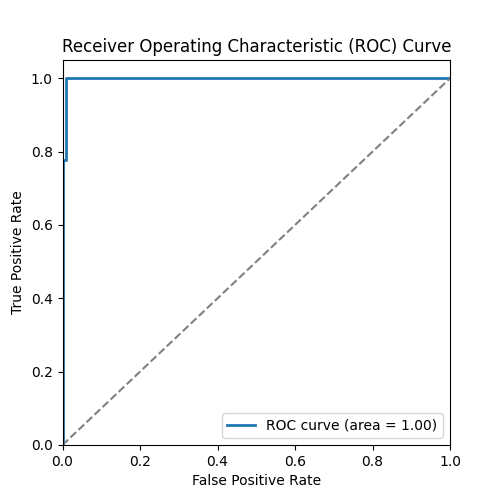

In [50]:
Image.open(f"{model_dir}/roc.png")

## Train Results

In [51]:
with open(f"{model_dir}/train_results.json") as f:
    train_results= json.load(f)

train_results

{'epoch': 10.0,
 'total_flos': 5.3955140555636736e+17,
 'train_loss': 0.12099567413330078,
 'train_runtime': 273.1699,
 'train_samples_per_second': 29.139,
 'train_steps_per_second': 1.83}